# Amazon Book Recommendation system for product co-purchasing network metadata

The dataset is available on the Stanford Network Analysis Project (SNAP) website from the following link: http://snap.stanford.edu/data/amazon-meta.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Graph Analytics Project')

### Import required libraries

In [3]:
!pip install stemming ntlk plotly

ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


In [3]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 739.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 580.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 664.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 879.3 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import string
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pylab as plt
from IPython.display import Image
from community import community_louvain
from collections import Counter
from itertools import chain
#pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'colab'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lokesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lokesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Open the file to read Amazon Product Metadata
df = open ('/Users/lokesh/Downloads/Database_433_Project/DataProcessing/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

### Description of the dataset
The data was collected in summer 2006 by crawling the Amazon website. The dataset provides information about product metadata and review metadata on 548,552 different products. For each product in the dataset, the following informations are available:
- Title
- Salesrank
- List of similar products (that get co-purchased with the current product)
- Detailed product categorization
- Product reviews: time, customer, rating, number of votes, number of people that found the review helpful

The data format is:
- ID: Product number (number 0, …, 548551)
- ASIN: Amazon Standard Identification Number is a 10-character alphanumeric unique identifier assigned by Amazon.com for product identification
- Title: Name/title of the product
- Group: The product group can be Book, DVD, Video or Music
- Sales rank: The Amazon sales rank represents how a product is selling in comparison to other products in its primary category. The lower the rank, the better a product is selling
- Similar: ASINs of co-purchased products, such as people who buy X also buy Y
- Categories: Location in product category hierarchy to which the product belongs (separated by |, category id in [...] )
- Reviews: Product review information such as the total number of reviews, average rating and the individual customer review information including time, user id, rating, total number of votes on the review, total number of helpfulness votes which means how many people found the review to be helpful




### Dataset Preprocessing





In [8]:
# Initialize a nested product dictionary that will hold cleaned up amazon product data.
amazonProducts= {}

Data Description:

- ID, ASIN, Title, Sales rank, Total reviews, and Average rating are the same as described above.
- All the categories associated with the ASIN are concatenated, and then the are subject to Text Preprocessing steps: lowercase, stemming, remove digit/punctuation, remove stop words, retain only unique words.
- The copurchased ASINs in the “similar” field are filtered down to only those ASINs that have metadata associated with it.

In [9]:
# Read the data from the Amazon file and fill the amazonProducts nested dictionary
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")): # a product block started
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip() # a product block ended
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
df.close

<function TextIOWrapper.close()>

## Focus only on the book category of products. Filter Amazon products dictionary down to only Group=Book and write it to amazonBooks dictionary.

In [10]:
#create book specific dictionary exclusively for books
amazonBooks = {}
for asin,metadata in amazonProducts.items():
    if (metadata['Group']=='Book'):
        amazonBooks[asin]=amazonProducts[asin]

#remove any copurchased items from copurchase list. If we don't have metadata associated with it
for asin, metadata in amazonBooks.items():
    amazonBooks[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonBooks.keys()])


In [11]:
amazonBooks

{'0827229534': {'Id': '1',
  'Title': 'Patterns of Preaching: A Sermon Sampler',
  'Categories': 'sermon preach christian spiritu book subject religion clergi',
  'Group': 'Book',
  'Copurchased': '0804215715 156101074X 0687023955 0687074231 082721619X',
  'SalesRank': 396585,
  'TotalReviews': 2,
  'AvgRating': 5.0,
  'DegreeCentrality': 0,
  'ClusteringCoeff': 0.0},
 '0738700797': {'Id': '2',
  'Title': 'Candlemas: Feast of Flames',
  'Categories': 'spiritu earth book religion subject base wicca witchcraft',
  'Group': 'Book',
  'Copurchased': '0738700827 1567184960 1567182836 0738700525 0738700940',
  'SalesRank': 168596,
  'TotalReviews': 12,
  'AvgRating': 4.5,
  'DegreeCentrality': 0,
  'ClusteringCoeff': 0.0},
 '0486287785': {'Id': '3',
  'Title': 'World War II Allied Fighter Planes Trading Cards',
  'Categories': 'general book subject garden craft hobbi home',
  'Group': 'Book',
  'Copurchased': '',
  'SalesRank': 1270652,
  'TotalReviews': 1,
  'AvgRating': 5.0,
  'DegreeCentr

In [12]:
amazonBooks['059035342X']

{'Id': '148185',
 'Title': "Harry Potter and the Sorcerer's Stone (Book 1)",
 'Categories': 'z age book rowl harri r magic fiction paperback humor general k illustr subject seri scienc mysteri fantasi literatur horror author adventur potter j children',
 'Group': 'Book',
 'Copurchased': '0439064864 0439136350 0439139600 043935806X',
 'SalesRank': 746,
 'TotalReviews': 5034,
 'AvgRating': 5.0,
 'DegreeCentrality': 0,
 'ClusteringCoeff': 0.0}

Use the copurchase data in Amazon books dictionary to create the copurchase graph structure as follows:
- NODES: are the ASINs
- EDGES: exist between two Nodes if the two ASINs were co-purchased
- EDGE WEIGHT: it is based on category similarity
- SIMILARITY: it is a measure between any two ASINs that were co-purchased and it can be calculated as the number of words that are common between categories of connected Nodes divided by the total number of words in both categories of connected nodes. The similarity range goes from 0 (most dissimilar) to 1 (most similar).



# Create a product copurchase graph for analysis based on Jaccard Similarity of common words in the Categories column

In [13]:
## The graph nodes are product ASINs, the graph edge exists
## if two products were copurchased with edge weight being
## a measure of category similarity between ASINs

copurchaseGraph = networkx.Graph()
for asin, metadata in amazonBooks.items():
    copurchaseGraph.add_node(asin)
    for a in metadata ['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity= 0
        n1= set((amazonBooks[asin]['Categories']).split())
        n2= set ((amazonBooks[a]['Categories']).split())
        n1In2 = n1 & n2 #intersection: number of words that are common between categories of connected nodes
        n1Un2 = n1 | n2 #union: total number of words in both categories of connected nodes
        if (len(n1Un2)) > 0:
            similarity = round (len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight = similarity)

## Add the graph-related measures Degree centrality and Clustering coefficient for each ASIN node and add it to amazonBooks metadata.

In [14]:
# Get degree centrality and clustering coefficients
## of each node and add it to amazonBooks metadata.

dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonBooks[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius = 1)
    metadata['ClusteringCoeff'] = round(networkx.average_clustering(ego), 2)
    amazonBooks[asin] = metadata

## Write out Amazon books data to the amazon-books.txt file and the copurchase graph data to the amazon-books-copurchase.edgelist file.


In [15]:
# Write amazonBooks data to file
df1 = open('./amazon-books.txt', 'w', encoding = 'utf-8', errors = 'ignore')
df1.write('Id\t' + 'ASIN\t' + 'Title\t'+
         'Categories\t' + 'Group\t' + 'Copurchased\t'+
         'SalesRank\t' + 'TotalReviews\t' + 'AvgRating\t'+
         'DegreeCentrality\t' + 'ClusteringCoeff\n')
for asin, metadata in amazonBooks.items():
    df1.write(metadata['Id'] + '\t' +
              asin + '\t' +
              metadata['Title'] + '\t' +
              metadata['Categories'] + '\t' +
              metadata['Group'] + '\t' +
              metadata['Copurchased'] +'\t' +
              str(metadata['SalesRank']) + '\t' +
              str(metadata['TotalReviews']) + '\t' +
              str(metadata['AvgRating']) + '\t' +
              str(metadata['DegreeCentrality']) + '\t' +
              str(metadata['ClusteringCoeff']) + '\n')
df1.close()

# Write copurchaseGraph to file
df1 = open('amazon-books-copurchase.edgelist', 'wb')
networkx.write_weighted_edgelist(copurchaseGraph, df1)
df1.close()

## Reading the text file

In [16]:
Books_File = open('amazon-books.txt', 'r', encoding = 'utf-8', errors = 'ignore')
Books = {}
Books_File.readline()
for line in Books_File:
    cell = line.split("\t")
    MetaData = {}
    MetaData['Id'] = cell[0].strip()
    ASIN = cell[1].strip()
    MetaData['Title'] = cell[2].strip()
    MetaData['Categories'] = cell[3].strip()
    MetaData['Group'] = cell[4].strip()
    MetaData['Copurchased'] = cell[5].strip()
    MetaData['SalesRank'] = int(cell[6].strip())
    MetaData['TotalReviews'] = int(cell[7].strip())
    MetaData['AvgRating'] = float(cell[8].strip())
    MetaData['DegreeCentrality'] = int(cell[9].strip())
    MetaData['ClusteringCoeff'] = float(cell[10].strip())
    Books[ASIN] = MetaData
Books_File.close()

In [17]:
Books_File = open("amazon-books-copurchase.edgelist", "rb")
Copurchase_Graph = networkx.read_weighted_edgelist(Books_File)
Books_File.close()

## Giving Book ASIN id as input for recommending books


In [18]:
print("Looking for Recommendations for Customer Purchasing this Book: ")
print("---------------------------------------------------------------")
# Purchased_ASIN = '0805047905'
Purchased_ASIN = input("Enter the ASIN of the book you purchased: ")
print("ASIN = ", Purchased_ASIN)
print("Title = ", Books[Purchased_ASIN]['Title'])
print("SalesRank = ", Books[Purchased_ASIN]['SalesRank'])
print("TotalReviews = ", Books[Purchased_ASIN]['TotalReviews'])
print("AvgRating = ", Books[Purchased_ASIN]['AvgRating'])
print("DegreeCentrality = ", Books[Purchased_ASIN]['DegreeCentrality'])
print("ClusteringCoeff = ", Books[Purchased_ASIN]['ClusteringCoeff'])

Looking for Recommendations for Customer Purchasing this Book: 
---------------------------------------------------------------


ASIN =  0805047905
Title =  Brown Bear, Brown Bear, What Do You See?
SalesRank =  171
TotalReviews =  172
AvgRating =  5.0
DegreeCentrality =  216
ClusteringCoeff =  0.65


## Visualize the Ego graph for the ASIN Product Query

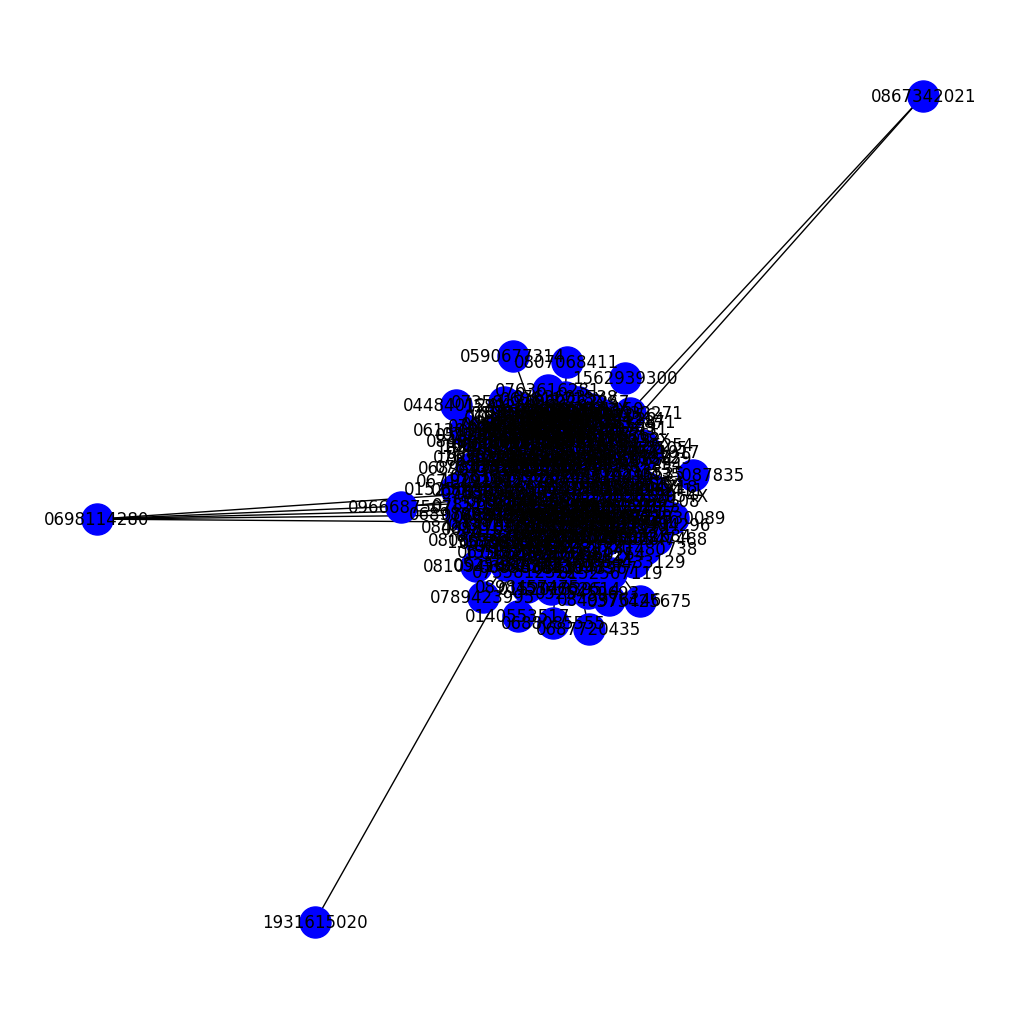

In [19]:
n = Purchased_ASIN
ego = networkx.ego_graph(Copurchase_Graph, n, radius = 1)
Purchased_ASIN_Ego_Graph = networkx.Graph(ego)
plt.figure(figsize = (10, 10))
pos = networkx.spring_layout(Purchased_ASIN_Ego_Graph)
plt.show(networkx.draw(Purchased_ASIN_Ego_Graph, pos, node_color = 'blue', node_size = 500, with_labels = True))

## Finding the books with a similarity measure based on threshold value

In [20]:
threshold = 0.5 # finding the nodes having similarity measure based on category above the threshold value
Purchased_ASIN_Ego_Trim_Graph = networkx.Graph()
for f, t, e in Purchased_ASIN_Ego_Graph.edges(data = True):
    if e['weight'] >= threshold:
        Purchased_ASIN_Ego_Trim_Graph.add_edge(f, t)

## View the purchased ASINs

In [21]:
Purchased_ASIN_Neighbors = Purchased_ASIN_Ego_Trim_Graph.neighbors(Purchased_ASIN)

In [22]:
ASIN_Meta = []
for asin in Purchased_ASIN_Neighbors:
    ASIN = asin
    Title = amazonBooks[ASIN]['Title']
    SalesRank = amazonBooks[ASIN]['SalesRank']
    TotalReviews = amazonBooks[ASIN]['TotalReviews']
    AvgRating = amazonBooks[ASIN]['AvgRating']
    DegreeCentrality = amazonBooks[ASIN]['DegreeCentrality']
    ASIN_Meta.append((ASIN, Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff))

## Show Top 5 recommendations

In [23]:
Top5_ByAbgRating_ThenByTotalReviews = sorted(ASIN_Meta, key = lambda x: (x[4], x[3]), reverse = True)[:5]

In [24]:
print()
print("Top 5 Recommendations By AvgRating Then By TotalReviews for Users Purchased The Book: ")
print("--------------------------------------------------------------------------------------")
print('ASIN\t', 'Title\t', 'SalesRank\t', 'TotalReviews\t', 'AvgRating\t', 'DegreeCentrality\t', 'ClusteringCoeff')
for asin in Top5_ByAbgRating_ThenByTotalReviews:
    print(asin)

print()


Top 5 Recommendations By AvgRating Then By TotalReviews for Users Purchased The Book: 
--------------------------------------------------------------------------------------
ASIN	 Title	 SalesRank	 TotalReviews	 AvgRating	 DegreeCentrality	 ClusteringCoeff
('0152010661', 'Time for Bed', 3122, 87, 5.0, 60, 0.0)
('0694006246', 'Big Red Barn Board Book', 4457, 40, 5.0, 27, 0.0)
('1581170769', 'What Makes a Rainbow?: Pop-Up', 40821, 29, 5.0, 7, 0.0)
('0694013013', 'From Head to Toe Board Book', 6026, 22, 5.0, 48, 0.0)
('0064435962', 'From Head to Toe', 187777, 22, 5.0, 5, 0.0)

